# Introduction
This notebook is dedicated to the **real-life application** of a **convolutional neural network (CNN)** to **classify multivariate medical transcriptions**. Labeled categorical samples undergo common **NLP preprocessing** methods in order to **extract relevant features** from **word-level embedding matrices**. Instead of classical approach making use of **dense layers**, this solution is **further enhanced** by taking advantage of **convolutions** and **max pooling**. 

In [28]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import re
import spacy
import nltk
from spacy.tokens.doc import Doc
from scipy.stats import skew, kurtosis, median_absolute_deviation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from typing import Generator, Iterable

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, Embedding
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
plt.style.use('seaborn-darkgrid')

# Medical transcriptions
Dataset used for the **Clinical Text Classification** is available publicly on [kaggle](https://www.kaggle.com/code/ritheshsreenivasan/clinical-text-classification/data).

## Download dataset

In [3]:
csv_path = '/content/drive/MyDrive/Medical transcription samples/mtsamples.csv.zip'

In [4]:
df = pd.read_csv(
    filepath_or_buffer=csv_path, 
    index_col=0
)

In [5]:
df.head(10)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
5,Morbid obesity. Laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","bariatrics, gastric bypass, eea anastomosis, r..."
6,"Liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","bariatrics, breast reconstruction, excess, lma..."
7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
8,Suction-assisted lipectomy - lipodystrophy of...,Bariatrics,Lipectomy - Abdomen/Thighs,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...","bariatrics, lipodystrophy, abd pads, suction-a..."
9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."


## Entry-stage data analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3931 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB


After taking a quick glance at the table we can notice that we are **missing 33 transcriptions**, which is the column containing predictors. As these are text transcriptions and such data is really complex and unique, instead of imputing I will simply **remove these rows** from my dataset later on.

In [7]:
spec_count = df['medical_specialty'].value_counts()
spec_count

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [8]:
spec_count.describe()

count      40.000000
mean      124.975000
std       197.667487
min         6.000000
25%        18.750000
50%        57.500000
75%       158.500000
max      1103.000000
Name: medical_specialty, dtype: float64

**Medical specialties** having **less than 57 transcriptions** make out **50%** of the distribution. **Medical specialty = 'Podiatry'** with **n = 47** can be used as a **threshold** to **reduce noise (very few entries)** in the data.

In [9]:
spec_count_filtered = spec_count[spec_count >= 47]
filtered_labels = spec_count_filtered.index

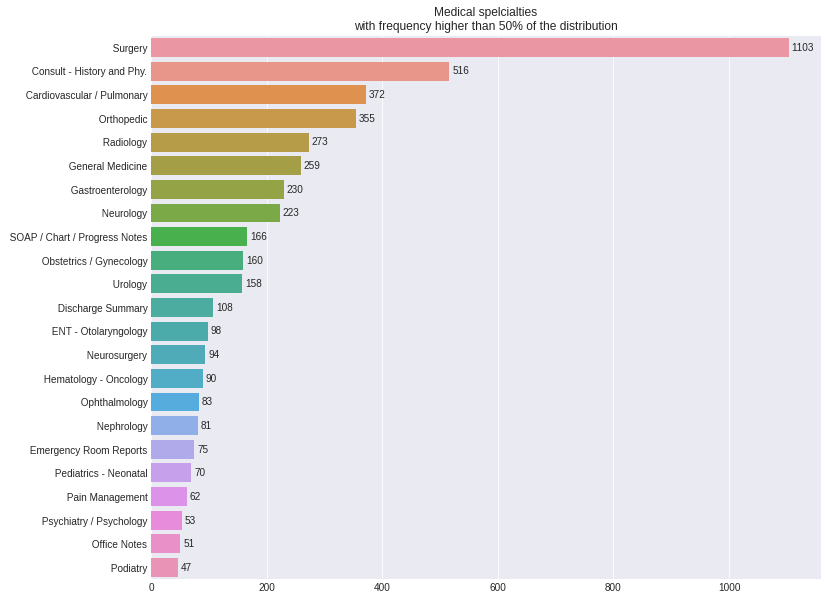

In [10]:
plt.figure(figsize=(12, 10))
sns.barplot(x=spec_count_filtered.values, y=spec_count_filtered.index)
plt.title('Medical spelcialties\nwith frequency higher than 50% of the distribution')
for i, v in enumerate(spec_count_filtered.values):
    plt.text(v + 5, i, str(v), va="center")
plt.show()

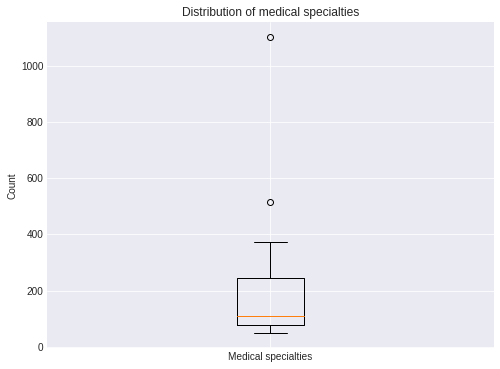

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(spec_count_filtered.values)
ax.set_xticklabels(["Medical specialties"])
ax.set_ylabel("Count")
ax.set_title("Distribution of medical specialties")
plt.show()

In [12]:
print('Skewness: {:.2f}'.format(skew(spec_count)))
print('Kurtosis: {:.2f}'.format(kurtosis(spec_count)))

Skewness: 3.38
Kurtosis: 13.34


As referred to the **Fisher’s definiton**, the kurtosis of the **normal distribution** is **zero**. **High kurtosis = 13.34** indicates a **leptokurtic distribution**, that is characterized by **high, thin peak** and **long, thick tail**. Furthermore, the distribution is **positively skewed**, as it has a **heavy, right-sided tail** and a **high standard deviation from the mean**. 

On the **box-plot** we observe that there is a **great variability** and **two extreme data points** fall **beyond the whiskers**. This visually represents the **heavy right-end tail** and **high-thin peak**, additionally supported by **large deviation from the mean**. These **highlighted points** are **outliers** and may **perhaps** be **dangerous** by **dominating other labels**. 

However, **removing outliers** from the data is legitimate only for **specific reasons**. 
* **Outliers** can be **very informative** about the **subject-area** and data collection process. 
* **Outliers increase the variability** in your data, which **decreases statistical power**. 

Consequently, **excluding outliers** can **cause your results** to become **statistically significant**. Since **most of the medical cases** refer to the **surgeries** and **from the medical personnel's perspective** it is a **purposeful dependency**, I want to **maintain the original population** in the **training data**.




# Preprocess data

In [13]:
class SpacyPreprocessor():
  def __init__(self):
    self.nlp = spacy.load(
      name='en_core_web_sm', 
      disable=["parser", "ner"]
    )
  
  def transform(self, X: Iterable) -> list:
    return [
      # Join preprocessed docs
      ' '.join(self.preprocess_document(doc))
      # Apply initial sentence-level cleaning
      for doc in self.nlp.pipe(self.clean_document(x) for x in X)
    ]
  
  @staticmethod
  def clean_document(text: str) -> str:
    # Replace all non-alphanumeric characters with a single space
    return re.sub('[^a-zA-Z]', ' ', text).casefold()
  
  @staticmethod  
  def preprocess_document(doc: Doc) -> Generator[str, None, None]:
    # Tokenize document
    for token in doc:
      # Remove non-alphanumeric tokens
      if not token.is_alpha:
        continue
        
      # Stopword removal
      if token.is_stop:
        continue
        
      # Lemmatization
      token = token.lemma_

      if len(token) > 2:
        # Yield token
        yield token

## Prepare dataset
My plan is to use a **convolutional neural network** that can **efficiently learn from data containing noise** and is **not affected by asymetrical data ditribution**. Therefore, **reducing outliers** in the **training data** as suggested in the **entry analysis** might **not** be **necessary**. Moreover, because we **remain all labels** in the dataset, we can then **predict even the least present medical specialties**. 

In [38]:
data = df.copy()

## Drop NaNs

In [39]:
data.dropna(subset=['medical_specialty', 'transcription'], inplace=True)

## Preprocess text
I am using **SpaCy pipeline** to **clean the text corpus, tokenize** and **lemmatize the words**. It is the **first preprocessing step** before creating any **word-level embeddings**.

In [40]:
spacy_preprocessor = SpacyPreprocessor()

In [41]:
data['transcription'] = spacy_preprocessor.transform(data['transcription'])

## Drop duplicates
I decided to **drop any rows** containing **same transformed transcriptions (documents)**, as it might **negatively impact classification**. I want to have **duplicated transcriptions** related **neigher to the same nor different target**. Maintaining **only unique transcriptions** enables me to **extract the most informative word-embeddings**.

In [42]:
data.drop_duplicates(subset=['transcription'], inplace=True)

## Clear vocabulary

In [43]:
words = data['transcription'].apply(lambda x: x.split())

In [44]:
all_words = np.hstack(words)
freq_dist = nltk.FreqDist(all_words)

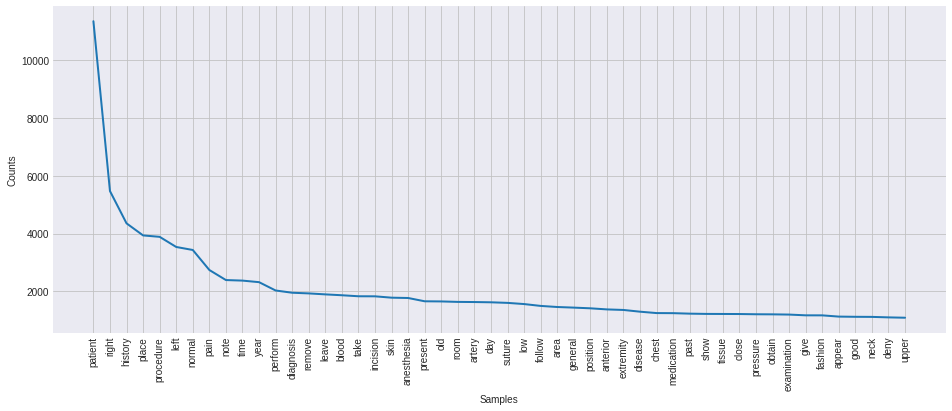

In [45]:
plt.figure(figsize=(16, 6))
freq_dist.plot(50, cumulative=False)

Notice how the word **patient** dominates the distribution. This graph depicts only a **tiny part of the vocabulary**, thus the **cut-off** for **dominating frequencies** might lay somewhere else. **Interquartile range (IQR)** is a **commonly applied method** to the **outlier detection** problems. 

In [46]:
freqs = pd.Series(freq_dist)
freqs.describe()

count    17302.000000
mean        33.590221
std        165.062085
min          1.000000
25%          1.000000
50%          3.000000
75%         13.000000
max      11349.000000
dtype: float64

In [47]:
# Calculate 1st and 3rd quantiles
q25, q75 = np.percentile(freqs, [25, 75])

# Evaluate the interquartile range (IQR)
iqr = q75 - q25

# Estimate the lower and higher bounds
low = 0. * q25 * iqr
high = 3. * q75 * iqr

print(f'Lower frequency cut-off: {low}')
print(f'Upper frequency cut-off: {high}')

Lower frequency cut-off: 0.0
Upper frequency cut-off: 468.0


In [48]:
print(f'Vocabulary size: {freqs.shape[0]}')
print(f'Vocabulary size after outlier removal: {freqs[(freqs >= low) & (freqs <= high)].shape[0]}')

Vocabulary size: 17302
Vocabulary size after outlier removal: 17074


In [49]:
words_to_replace = freqs[(freqs < low) | (freqs > high)].index
words_to_replace

Index(['year', 'old', 'white', 'female', 'present', 'complaint', 'allergy',
       'past', 'work', 'time',
       ...
       'ray', 'report', 'renal', 'lesion', 'therapy', 'chronic', 'vein',
       'minute', 'femoral', 'fracture'],
      dtype='object', length=228)

In [50]:
data['transcription'] = data['transcription'].apply(lambda x: ' '.join([s for s in x.split() if s not in words_to_replace]))

**Vocabulary** currently consists of **17302 words**, however the word frequencies vary within a very wide spectrum. After reducing the outliers based on the **modified interquartile range (IQR)** of the **frequency distribution**, the **vocabulary shrinks to 17074**. 
> Notice that I only take into account the **upper bound**, as some of the words having **least presence** might induce **a lot of semantical importance**. 

## Remove samples without informative tokens
Further **vectorization** of the corpus involves a range of **n-grams** incorporating **up to 3 words** into a **single embedding**, therefore any transformed transcriptions having **less words** should be **removed**.  

In [51]:
words_count = words.apply(len)
words_count.describe()

count    2354.000000
mean      246.889550
std       159.473999
min         1.000000
25%       130.000000
50%       216.500000
75%       325.750000
max      1447.000000
Name: transcription, dtype: float64

In [52]:
data = data[data['transcription'].apply(lambda x: len(x.split()) > 2)]

# Create feature matrix and target vector

In [53]:
X = data['transcription'].values
y = data['medical_specialty'].str.strip().values

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Encoding labels
Our labels are **categorical variables**. Prior to **one-hot encoding** the target, the text should be **encoded to numerical form**.

In [55]:
labels = np.unique(y)
n_classes = len(labels)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

oh_encoder = OneHotEncoder(categories=[labels], sparse=False)
y_train_oh = oh_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_oh = oh_encoder.transform(y_test.reshape(-1, 1))

## TF-IDF vectorization
While following the **standard frequency-based** approach, the **pattern of information** carried across terms that are **rarely present** but **carry a high amount of information** for a document or an **evident pattern** across similar documents is **lost**. The **TF-IDF** approach for **weighing terms** in a **text corpus** helps **mitigate this issue**. 

* **Term frequency (TF)** takes into account **how frequently
a term occurs in a document**. Since most of the documents in a **text corpus** are of **different lengths**, it is very likely that a **term would appear more frequently in longer documents rather than in smaller ones**. This calls for **normalizing the frequency of the term** by **dividing it by the count of the terms in the document**. **TF-IDF** is also an **occurrence-based** method for **vectorizing text** and **extracting relevant features** out of it.

* **Inverse document frequency (IDF)** measures the **importance of a term** in a document. The usage of **TF** only would provide **more weightage to terms that occur very frequently**. As part of **IDF**, just the opposite is done, 
whereby the **weights of frequently occurring terms are suppressed** and the **weights of possibly more meaningful but less frequently occurring terms are
scaled up**.

In [56]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3), 
    max_features=5000,
    lowercase=False
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## T-SNE plot
**T-distributed Stochastic Neighbor Embedding (t-SNE)** is a **visual representation** of **high-dimensional** data. It **converts similarities between data points** to **joint probabilities** and tries to **minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding** and the **high-dimensional data**. 
> As it is **highly recommended** to use **another dimensionality reduction method** (e.g. **PCA** for **dense** data or **Truncated SVD** for **sparse** data) to **reduce the number of dimensions** to a reasonable amount if the **number of features is very high** - a **text corpus** is a great example. This will **suppress some noise** and **speed up the computation of pairwise distances between samples**.

In [59]:
def plot_tsne(X_tsne, y):
  plt.figure(figsize=(16, 10))
  sns.scatterplot(
      x=X_tsne[:, 0], 
      y=X_tsne[:, 1],
      hue=y,
      palette=sns.color_palette('hsv', np.unique(y).shape[0]),
      legend='full',
      alpha=0.5
  )
  plt.title('t-SNE plot')
  plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
  plt.show()

In [60]:
tsne = TSNE(
  n_components=2,
  init='random',
  learning_rate='auto',
  perplexity=40,
  random_state=33
)

X_tsne = tsne.fit_transform(scipy.sparse.vstack([X_train_tfidf, X_test_tfidf]))
y_tsne = np.hstack([y_train, y_test])

In [61]:
filtered_idx = np.where(np.isin(y_tsne, filtered_labels.str.strip()))

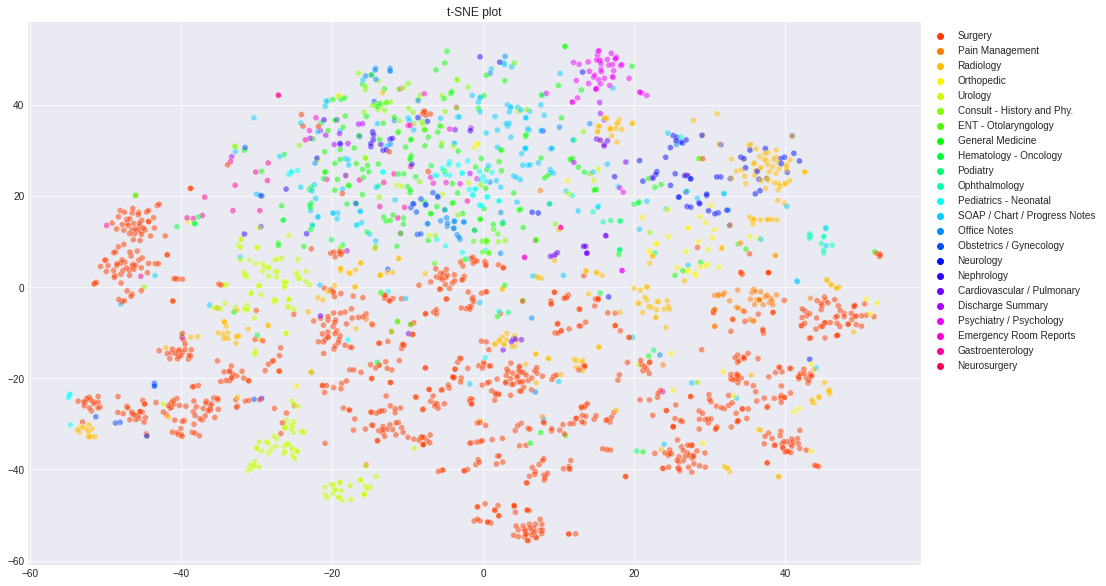

In [62]:
plot_tsne(X_tsne[filtered_idx], y_tsne[filtered_idx])

## Latent Semantic Analysis (LSA)
**Truncated singular value decomposition (SVD)**, also referred to as **Latent Semantic Analysis (LSA)** performs **linear dimensionality reduction**. In contrary to **Principal Component Analysis (PCA)**, this estimator does **not center** the data before computing the **singular value decomposition**. This means it can work with **sparse matrices**, like **word-embedding matrices**, **efficiently**.
> In particular, **truncated SVD** works on **term count/tf-idf matrices** as returned by the **vectorizers**. In that context, it is known as **latent semantic analysis (LSA)**.

In [57]:
#  For LSA (Latent Semantic Analysis), a value of 100 is recommended.
svd = TruncatedSVD(n_components=100)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

In [58]:
print('Explained variance: {:.2f}'.format(sum(svd.explained_variance_ratio_)))

Explained variance: 0.30


# Logistic Regression
**Logistic regression** is a **simple** and **efficient** method for **binary** and **linear classification** problems. It is a **classification** model, which is **very easy to realize** and **achieves very good performance** with **linearly separable classes**. 
> Results from the **Logistic Regression** model are treated by me as a **ground truth** for later **comparison** of the **predictions returned by the CNN**.

In [31]:
lr = LogisticRegression()
lr.fit(X_train_svd, y_train_encoded)
lr.score(X_test_svd, y_test_encoded)

0.6893617021276596

# Convolutional Neural Network
The **convolutions** make it possible to **capture spatial relations** in data, such as images. However, **text** has **more of a sequential relationship**, where **words in the vicinity** account for **more information for that particular word** rather than **any word appearing in a line right above them**. Hence, for **text** data, we look at **one-dimensional spatial relationships** and **leverage** the **convolutional layers** for this purpose. 
> This is **similar** to **going through n-grams**, wherein there would be **overlaps in consecutive n-gram windows**. The value of **n** would be specified by the **kernel size** parameter you provide as **input** to the
**convolutional layer**.


In [32]:
max_len = 10

X_train_3d, X_test_3d = map(
    lambda x: np.reshape(x, newshape=(x.shape[0], max_len, -1)),
    [X_train_svd, X_test_svd]
)

in_shape = X_train_3d.shape[1:]
in_shape

(10, 100)

**Convolutional input layer** expects the data to come in a **standardized, three-dimensional matrix**. Each of the **vector** in the **matrix** should have a **fixed length** defined as the **length of the shortest vector rounded to the closest 10** - in our case that's just **10**. If any of the **vectors** contain more than **10 elements**, these will be **subsampled** to keep the **values** for the first **10 elements**.
> **After applying LSA**, our **vectors** contain **100 features** and hence, by **dividing it by 10** we receive an **input shape = (10 x 10)** - there is **no** need to **explicitly add zero-padding to the vectors**.


In [953]:
def plot_history(history):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
  metrics = ['loss', 'categorical_accuracy']
  for i, metric in enumerate(metrics):
    yy = history[metric]
    yy_val = history[f'val_{metric}']
    xx = np.arange(len(yy))
    ax[i].plot(xx, yy, color='b', label='Training')
    ax[i].plot(xx, yy_val, color='r', label='Validation')
    ax[i].set_title(metric)
    ax[i].legend()

## Define **callbacks** used during the **training phase**.

In [33]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    min_lr=1e-4,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-4,
    patience=5,
    verbose=1
)

## Build the **neural network**

In [941]:
model = Sequential([
  Conv1D(
      filters=128, 
      kernel_size=5, 
      input_shape=in_shape,
      activation='relu'
  ),
  GlobalMaxPooling1D(),
  Dense(256, activation='relu'),
  Dropout(0.2),
  Dense(n_classes, activation='softmax')
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_41 (Conv1D)          (None, 6, 128)            6528      
                                                                 
 global_max_pooling1d_40 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_80 (Dense)            (None, 256)               33024     
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_81 (Dense)            (None, 39)                10023     
                                                                 
Total params: 49,575
Trainable params: 49,575
Non-trainable params: 0
_________________________________________________

## **Train** the model

In [942]:
history = model.fit(
    X_train_3d,
    y_train_oh,
    validation_split=0.05,
    epochs=50, 
    batch_size=256,
    callbacks=[reduce_lr, ] # early_stopping],
).history

Epoch 1/50
7/7 [==============================] - 1s 44ms/step - loss: 2.9378 - categorical_accuracy: 0.3716 - val_loss: 2.2026 - val_categorical_accuracy: 0.4043 - lr: 0.0100
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 2.3914 - categorical_accuracy: 0.4126 - val_loss: 2.1300 - val_categorical_accuracy: 0.4043 - lr: 0.0100
Epoch 3/50
7/7 [==============================] - 0s 11ms/step - loss: 2.2346 - categorical_accuracy: 0.4148 - val_loss: 2.0572 - val_categorical_accuracy: 0.4043 - lr: 0.0100
Epoch 4/50
7/7 [==============================] - 0s 10ms/step - loss: 2.1115 - categorical_accuracy: 0.4148 - val_loss: 1.8849 - val_categorical_accuracy: 0.4043 - lr: 0.0100
Epoch 5/50
7/7 [==============================] - 0s 10ms/step - loss: 1.9709 - categorical_accuracy: 0.4345 - val_loss: 1.7022 - val_categorical_accuracy: 0.5532 - lr: 0.0100
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 1.7898 - categorical_accuracy: 0.5374 - val_loss:

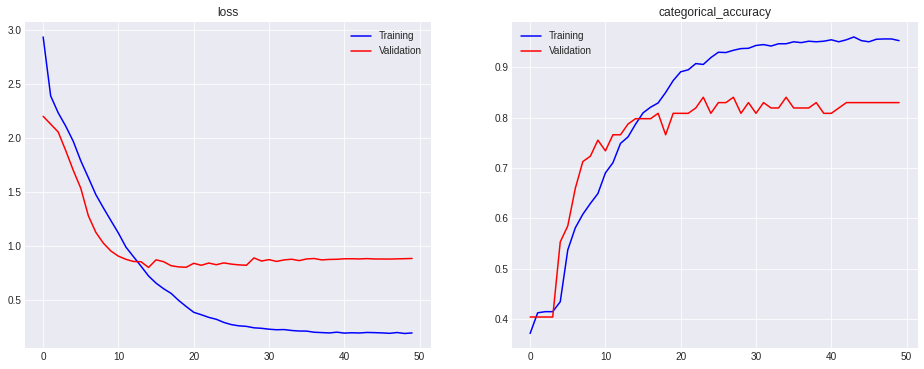

In [954]:
plot_history(history)

## **Evaluate** the model

In [943]:
loss, accuracy = model.evaluate(X_test_3d, y_test_oh, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Testing Accuracy: 0.7527


# Summary
**Text** follows **similar compositional structure as image**, where **sequential characters** form **n-grams**, **stems**, **words**, **sentences** etc. Therefore **CNNs** are widely applied for **text classification tasks**. Thanks to the **concept of sliding (convolving) a pre-determined window (filter kernel)**, the **convolutional** and **pooling layers** allow the model to **learn** the **local indicators regardless of their level** (**character-**, **word-**, or even **sentence-level embeddings**). The central idea behind the **pooling** is that we **divide the output layers into subsections** and **calculate a value** that **best represents the output**. This **dimensionality reduction** inside the fully connected network is proven to be **effective** in **learning higher-order representations** of the data while **reducing the number of parameters**. 

Although the **CNNs** use the **sliding filter** to **extract informative features from text**, I discovered that **feeding the CNN** with a **TF-IDF vectorized embeddings of word n-grams** results in **higher accuracy** as compared to a **simple, occurence-based embeddings of preprocessed, singular tokens**. 

Furthermore, using **all tokens regardless of their frequency in the corpus** delivers **insignificantly lower accuracy** (72-74%) as opposed to the **tokens filtered using a modified IQR approach** (71-75%). It comes from the fact that the **TF-IDF** and **truncated SVD transformers** can **extract relevant indicators from sparse data effectively**, in outcome returning **vector embeddings informative enough** to **explain the semantics of the entire sentence**. Even after **reducing the initial vocabulary size** to **3200**, which is less than **20%** of the **original size**, the **test accuracy dropped just slightly** (71-73%). **Fixed number of max features = 5000** in the **TF-IDF vectorizer** has proven to work as a **perfect threshold between too poor and too rich vocabulary**. The **LSA** of the **TF-IDF vectors** configured according to the **thumb rule** and setting the **number of components = 100** resulted in **the highest performance**, although the **explained variance is only 30%**. Converting the **sparse matrix** into a **dense representation** and applying the **PCA** and with **threshold** set to **95% explained variance** is **not the best practice** and the **overall model classification capabilities suffer**. 

As **suggested** at the **entry stage analysis**, the **presence of outliers** in the **target** data does **not deteriorate** model's **performance**, while still remaining the **primary distribution** of **medical specialties** - **manipulating the original population** could result in **non-representative predictions**.  